<a href="https://colab.research.google.com/github/riteshcanfly/Python-AI-book/blob/master/timeseries_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Time series Analysis**

 A time series data is a collection of observations x(t), where each data point is recorded at time t. The time can be discrete, t = 1,2,3,..., or
continuous t > 0.

There can be mainly four objectives of time series analysis 
* Exploratory
  - finding the relationship among variables
  - understanding seasonal effects
* Signal extraction
  - Noise removal
* Prediction
  - predict future values based on the previous values
* Data compression
  - compress the data for signal delivery or better understanding

In this recipe we will perform the following objectives
*   Generate some time series data and analyze it using pytorch LSTM framework
* Use Prophet by Facebook on real data


We will perform various traditional and modern methods to understand and analyse the forecasting of time series data. We wil analyze the weather data for this purpose from openml.

As usual we will load the data and perform various preprocessing. 

In [0]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

In [0]:
data = fetch_openml(data_id=41187)
data

{'DESCR': '**Weekly carbon-dioxide concentration averages derived from continuous air samples for the Mauna Loa Observatory, Hawaii, U.S.A.**<br><br>\nThese weekly averages are ultimately based on measurements of 4 air samples per hour taken atop intake lines on several towers during steady periods of CO2 concentration of not less than 6 hours per day; if no such periods are available on a given day, then no data are used for that day. The _Weight_ column gives the number of days used in each weekly average. _Flag_ codes are explained in the NDP writeup, available electronically from the [home page](http://cdiac.ess-dive.lbl.gov/ftp/trends/co2/sio-keel-flask/maunaloa_c.dat) of this data set. CO2 concentrations are in terms of the 1999 calibration scale (Keeling et al., 2002) available electronically from the references in the NDP writeup which can be accessed from the home page of this data set.\n<br><br>\n### Feature Descriptions\n_co2_: average co2 concentration in ppvm <br>\n_year_:

We will use the scikit example  load_mauna_loa_atmospheric_co2 function for this purpose.
(https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py) 

This data is one of the earliest recordings available on atmospheric recordings of Co2. As it will be later observed, this data follows a sinusoidal pattern with the Co2 concentration rising in winters and falling in the summers owing to the falling of the plant and vegetation in the winter season. This has started happening quite quickly these days.


```
def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1, 1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs
```

This will spit out the average CO2 concentration measured at Mauna Loa Observatory in Hawaii from 1958 to 2001. We will try to model the CO2 concentration with respect to t.

In [0]:
def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []
 
    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target
 
    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1
 
    months = np.asarray(months).reshape(-1, 1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs
X,y = load_mauna_loa_atmospheric_co2()


In [0]:
df_CO2 = pd.DataFrame(data = X, columns = ['Year'])
df_CO2['CO2 in ppm'] = y

Text(0.5, 0.98, 'CO2 conc. mauna_loa 1958-2001')

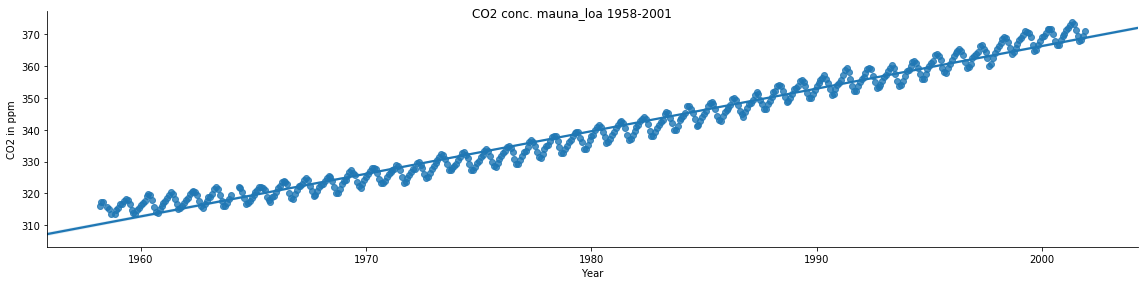

In [0]:
lm = sns.lmplot(x='Year', y='CO2 in ppm', data=df_CO2, height=4, aspect=4)
fig = lm.fig 
fig.suptitle("CO2 conc. mauna_loa 1958-2001", fontsize=12)

# We will take up the following models and show their usage step by step
  * Autoregressive Integrated Moving Average (ARIMA) model
  * Seasonal Autoregressive Integrated Moving-Average (SARIMA) model



In [0]:
# ARIMA model
# Autoregression of the time series data

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

In [0]:
def ARIMA_model(train, test):
  history = [x for x in train]
  predictions = list()
  for t in range(len(test)):
	  model = ARIMA(history, order=(5,1,0))
	  model_fit = model.fit(disp=0)
	  output = model_fit.forecast()
	  yhat = output[0]
	  predictions.append(yhat)
	  obs = test[t]
	  history.append(obs)
	  print('predicted=%f, expected=%f' % (yhat, obs))
  error = mean_squared_error(test, predictions)
  print('Test MSE: %.3f' % error)
  return predictions, error


In [0]:
future = int(len(y) * 0.9)
print('number of train samples: %d test samples %d'%(future, len(y)-future))
train, test = y[0:future], y[future:len(y)]
test_year = X[future:len(X)]
predictions_ARIMA, error_ARIMA = ARIMA_model(train, test)


number of train samples: 468 test samples 53
predicted=363.620296, expected=362.460000
predicted=361.265540, expected=360.150000
predicted=358.821465, expected=360.750000
predicted=362.374355, expected=362.380000
predicted=364.472777, expected=364.250000
predicted=365.613809, expected=365.340000
predicted=365.863984, expected=366.200000
predicted=366.241549, expected=367.375000
predicted=367.821750, expected=368.525000
predicted=368.910941, expected=369.140000
predicted=369.090018, expected=368.750000
predicted=368.000613, expected=367.600000
predicted=366.494709, expected=365.720000
predicted=364.402940, expected=363.925000
predicted=363.048904, expected=364.320000
predicted=365.585745, expected=365.550000
predicted=367.193508, expected=366.925000
predicted=368.007658, expected=368.120000
predicted=368.863230, expected=368.850000
predicted=368.931569, expected=369.600000
predicted=369.725286, expected=370.975000
predicted=371.737093, expected=370.840000
predicted=370.227210, expected=

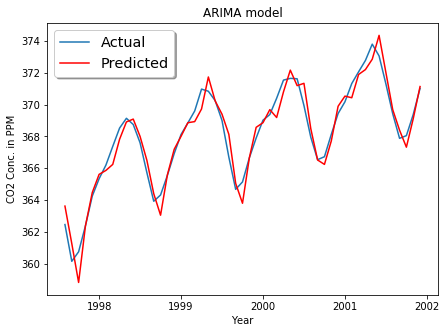

In [0]:
fig, ax = plt.subplots(figsize = (7,5))
ax.plot(test_year, test, label='Actual')
ax.plot(test_year,predictions_ARIMA, color='red',label='Predicted')

legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.title('ARIMA model')
plt.xlabel('Year')
plt.ylabel('CO2 Conc. in PPM')

plt.show()


In [0]:
test_year[5:18]

array([[1998.        ],
       [1998.08333333],
       [1998.16666667],
       [1998.25      ],
       [1998.33333333],
       [1998.41666667],
       [1998.5       ],
       [1998.58333333],
       [1998.66666667],
       [1998.75      ],
       [1998.83333333],
       [1998.91666667],
       [1999.        ]])

In [0]:
# The order and seasonal order parameters 
def SARIMA_model(train, test):
  history = [x for x in train]
  predictions = list()
  for t in range(len(test)):
	  model = SARIMAX(history, order=(1, 1, 1), seasonal_order=(1, 1, 1, 1))
	  model_fit = model.fit(disp=0)
	  output = model_fit.forecast()
	  yhat = output[0]
	  predictions.append(yhat)
	  obs = test[t]
	  history.append(obs)
	  print('predicted=%f, expected=%f' % (yhat, obs))
  error = mean_squared_error(test, predictions)
  print('Test MSE: %.3f' % error)
  return predictions, error


In [0]:
# take the future as the last 12 months keeping in view the seasonality of the C02 peaks
future = 12
print('number of train samples: %d test samples %d'%(len(y)-future,future) )
train, test = y[:-future], y[-future:]
test_year = X[-future:]
predictions_SARIMA, error_SARIMA = SARIMA_model(train, test)


number of train samples: 509 test samples 12
predicted=370.710211, expected=370.175000
predicted=370.760624, expected=371.325000
predicted=372.594269, expected=372.060000
predicted=372.679121, expected=372.775000
predicted=373.492858, expected=373.800000
predicted=374.905714, expected=373.060000
predicted=371.858433, expected=371.300000
predicted=369.308769, expected=369.425000
predicted=367.539445, expected=367.880000
predicted=366.422806, expected=368.050000
predicted=368.662261, expected=369.375000
predicted=370.971151, expected=371.020000
Test MSE: 0.667


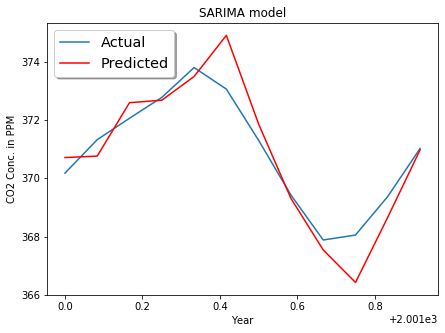

In [0]:
fig, ax = plt.subplots(figsize = (7,5))
ax.plot(test_year, test, label='Actual')
ax.plot(test_year,predictions_SARIMA, color='red',label='Predicted')

legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.title('SARIMA model')
plt.xlabel('Year')
plt.ylabel('CO2 Conc. in PPM')

plt.show()

In [0]:
import statsmodels.api as stm

In [0]:
d = stm.datasets.co2.load_pandas()
co2 = d.data
co2.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [0]:
# Handle missing values in the data
#y = co2['co2'].resample('MS').mean()
y = co2['co2']

In [0]:
y = y.fillna(y.interpolate())
y.isnull().sum()

0

In [0]:
y

1958-03-29    316.1
1958-04-05    317.3
1958-04-12    317.6
1958-04-19    317.5
1958-04-26    316.4
              ...  
2001-12-01    370.3
2001-12-08    370.8
2001-12-15    371.2
2001-12-22    371.3
2001-12-29    371.5
Freq: W-SAT, Name: co2, Length: 2284, dtype: float64

**Decomposition of signal using the statsmodel method**

statsmodels provides a method to perform the decomposition of the signal based on seasonality of the data. Detailed mathematical analysis can be found at , “[STL: A Seasonal-Trend Decomposition Procedure Based on Loess.](http://www.wessa.net/download/stl.pdf)”

The script here shows the time-series seasonal decomposition of the Co2 data showing a clear seasonal variation in the Co2 concentration whuch can be taraced back to the biology.

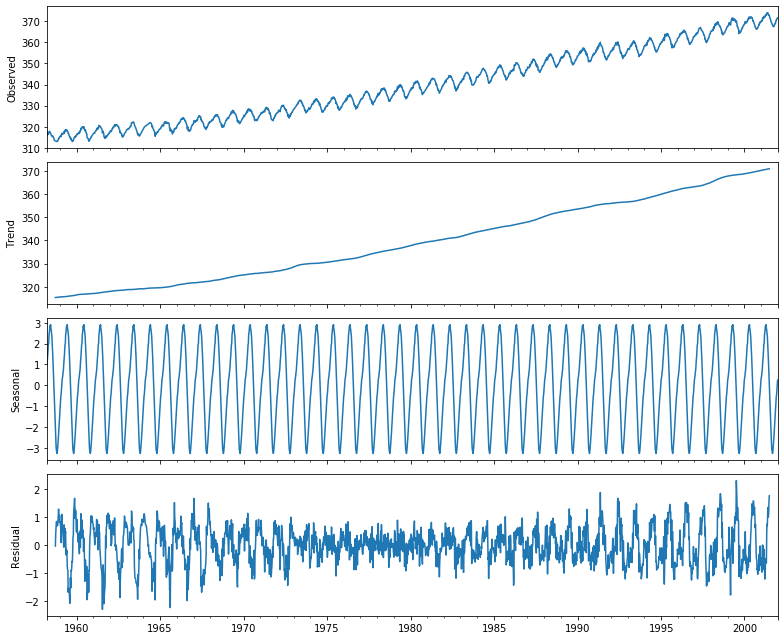

In [0]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

result = stm.tsa.seasonal_decompose(y, model='additive')
pd.plotting.register_matplotlib_converters()
result.plot()
plt.show()

In [0]:
df_CO2_fb = co2.reset_index()
df_CO2_fb.columns = ['ds', 'y']
df_CO2_fb['ds']= df_CO2_fb['ds'].apply(pd.to_datetime)
df_CO2_fb = df_CO2_fb.set_index('ds')

df_CO2_fb.head()

,y
ds,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [0]:
df_CO2_fb.shape

(2284, 2)


**Prophet**

Prophet is a a library provided by Facebook for forecasting time series data. It works on  an additive model and fits non-linear models. The library works best when the data has strong seasonal effects and has enough historic trend available.

 Details can be found at
 
 https://facebook.github.io/prophet/




In [0]:
!pip install fbprophet

In [0]:
from fbprophet import Prophet

In [0]:
#prediction_size = 52
#train_df = df_CO2_fb[:-prediction_size]

train_df = df_CO2_fb['1958':'1997']
test_df = df_CO2_fb['1998':'2001']
train_df = train_df.reset_index()
test_df = test_df.reset_index()
test_df.head()


,ds,y
0,1998-01-03,365.2
1,1998-01-10,365.3
2,1998-01-17,365.3
3,1998-01-24,365.3
4,1998-01-31,365.6


In [0]:
import seaborn as sns


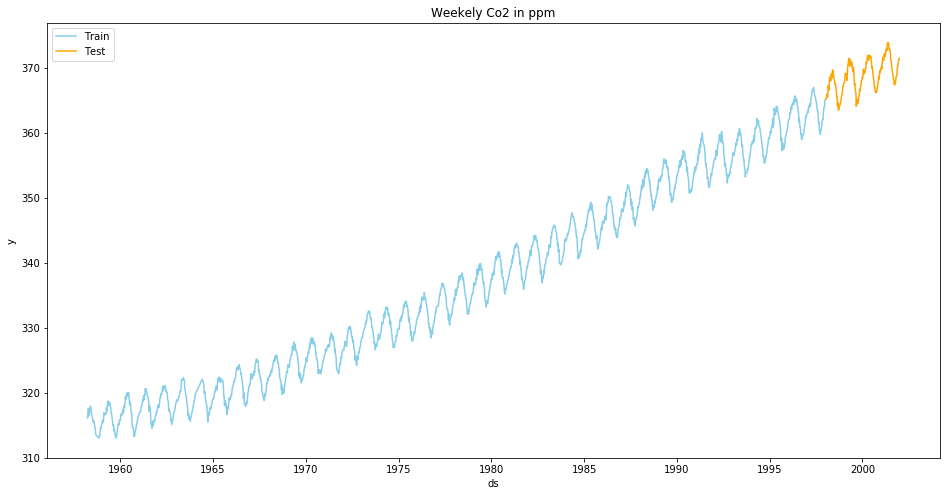

In [0]:
plt.figure(figsize=(16,8))
ax = sns.lineplot(x='ds', y='y', color='skyblue', data=train_df, label='Train')
sns.lineplot(x='ds', y='y', color='orange', label='Test', data=test_df, ax=ax)
plt.title('Weekely Co2 in ppm');

In [0]:
train_df['mean_baseline'] = train_df['y'].mean()
test_df['mean_baseline']  = test_df['y'].mean()
print('Average Co2 conc (ppm) in the train set:', train['y'].mean())

Average Co2 conc (ppm) in the train set: 337.1754960317457


In [0]:
train_df['naive_baseline'] = train['y'].shift(1).bfill()
train_last_observation = train_df['naive_baseline'].iloc[-1]
test_df['naive_baseline'] = train_last_observation

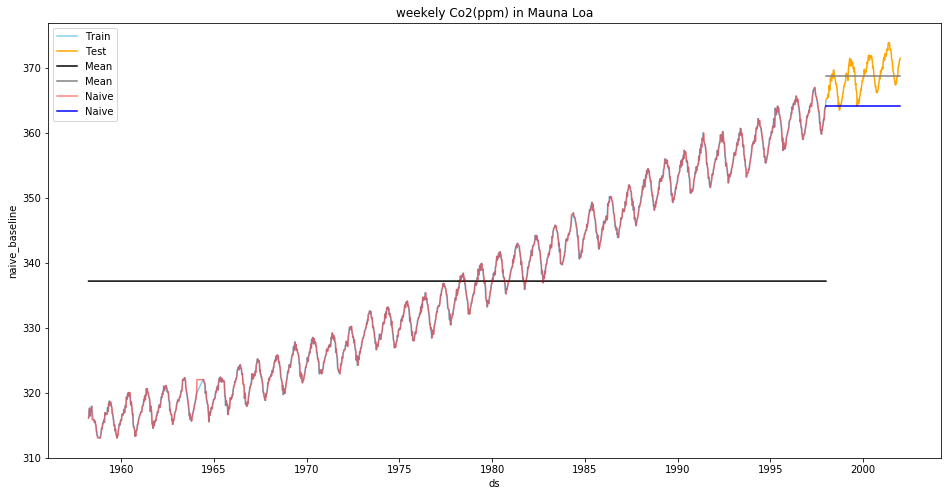

In [0]:
plt.figure(figsize=(16,8))
ax = sns.lineplot(x='ds', y='y', color='skyblue', data=train_df, label='Train')
sns.lineplot(x='ds', y='y', color='orange', label='Test', data=test_df, ax=ax)
sns.lineplot(x='ds', y='mean_baseline', color='black', data=train_df, label='Mean', ax=ax)
sns.lineplot(x='ds', y='mean_baseline', color='gray', data=test_df, label='Mean',ax=ax)
sns.lineplot(x='ds', y='naive_baseline', color='red', alpha=.5, data=train_df, label='Naive', ax=ax)
sns.lineplot(x='ds', y='naive_baseline', color='blue', data=test_df, label='Naive',ax=ax)

plt.title('weekely Co2(ppm) in Mauna Loa');

In [0]:
from sklearn.metrics import mean_absolute_error
train_df = train_df.fillna(method='ffill')
test_df = test_df.fillna(method='ffill')
train_mae = mean_absolute_error(train_df['y'], train_df['mean_baseline'])
test_mae = mean_absolute_error(test_df['y'], test_df['mean_baseline'])
print('Train MAE, for mean baseline:', train_mae)
print('Test MAE, for mean baseline:', test_mae)

Train MAE, for mean baseline: 13.212316551921946
Test MAE, for mean baseline: 2.0077608113367393


In [0]:
train_mae = mean_absolute_error(train_df['y'], train_df['naive_baseline'])
test_mae = mean_absolute_error(test_df['y'], test_df['naive_baseline'])
print('Train MAE, for naive baseline:', train_mae)
print('Test MAE, for naive baseline:', test_mae)

Train MAE, for naive baseline: 0.38154216867469865
Test MAE, for naive baseline: 4.578468899521542


In [0]:
Co2_model= Prophet(interval_width=0.95)

Co2_model.fit(train_df)
train_forecast = Co2_model.predict(train_df)
test_forecast = Co2_model.predict(test_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


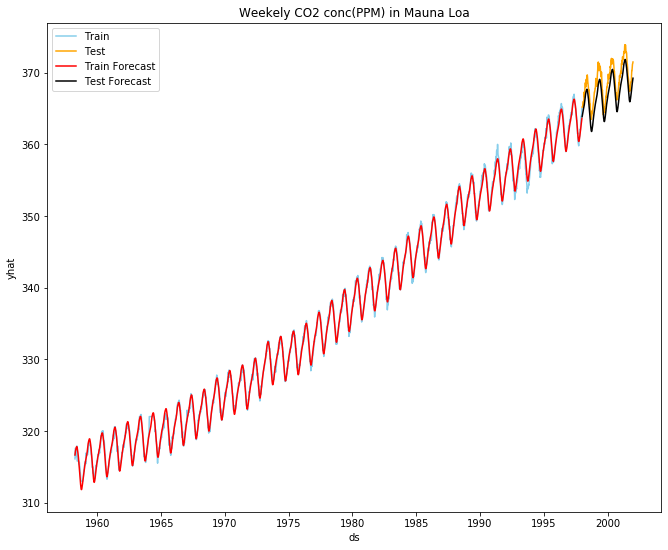

In [0]:
ax = sns.lineplot(x='ds', y='y', color='skyblue', data=train_df, label='Train')
sns.lineplot(x='ds', y='y', color='orange', label='Test', data=test_df, ax=ax)
sns.lineplot(x='ds', y='yhat', color='red', label='Train Forecast', data=train_forecast, ax=ax)
sns.lineplot(x='ds', y='yhat', color='black', label='Test Forecast', data=test_forecast, ax=ax)

plt.title('Weekely CO2 conc(PPM) in Mauna Loa');


In [0]:
train_mae = mean_absolute_error(train_df['y'], train_forecast['yhat'])
test_mae = mean_absolute_error(test_df['y'], test_forecast['yhat'])
print('Train MAE for Prophet (default params):', train_mae)
print('Test MAE for Prophet (default params):', test_mae)

Train MAE for Prophet (default params): 0.36182997629622954
Test MAE for Prophet (default params): 1.7989954111636965


In [0]:
fut = Co2_model.make_future_dataframe(periods=12, freq='M')
forecast_df = Co2_model.predict(fut)


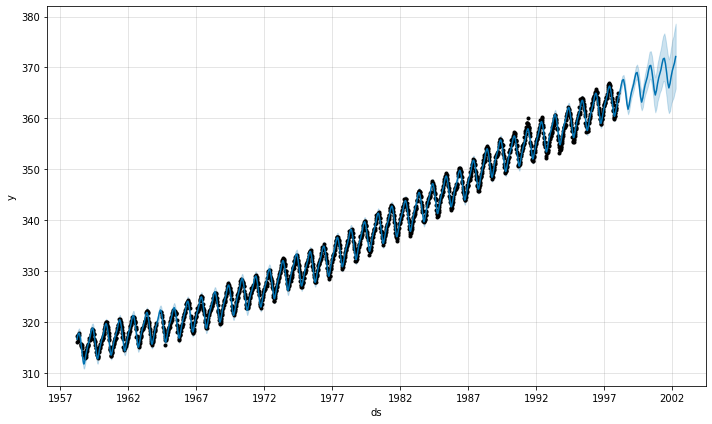

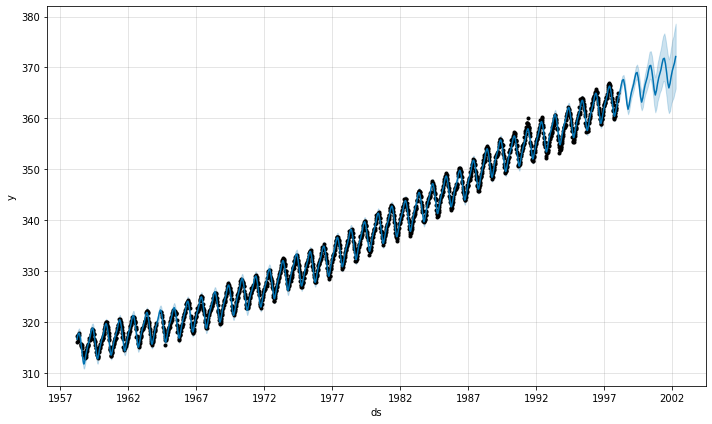

In [0]:
Co2_model.plot(forecast_df)

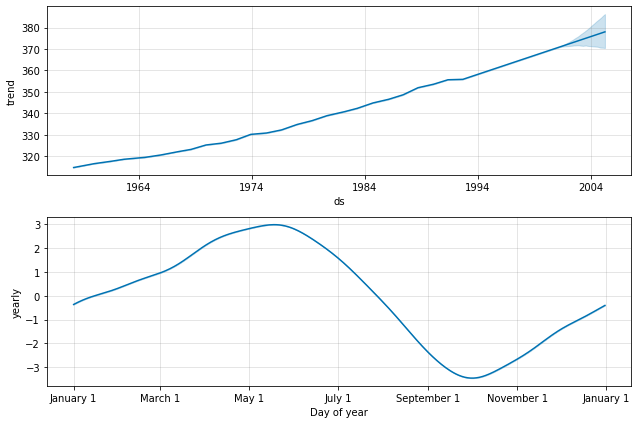

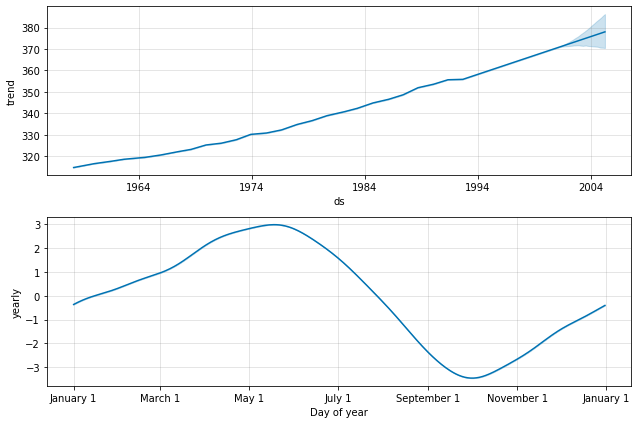

In [0]:
Co2_model.plot_components(forecast_df)

In [0]:
forecast_df.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2122,2001-11-30,369.672290,362.899582,373.956335,364.193929,375.512854,-1.434490,-1.434490,-1.434490,-1.434490,-1.434490,-1.434490,0.0,0.0,0.0,368.237799
2123,2001-12-31,369.790725,363.527945,375.416088,364.181025,375.778684,-0.417901,-0.417901,-0.417901,-0.417901,-0.417901,-0.417901,0.0,0.0,0.0,369.372823
2124,2002-01-31,369.909159,364.044283,376.135445,364.148675,376.043564,0.260526,0.260526,0.260526,0.260526,0.260526,0.260526,0.0,0.0,0.0,370.169686
2125,2002-02-28,370.016133,364.961402,377.391576,364.075116,376.351774,0.922979,0.922979,0.922979,0.922979,0.922979,0.922979,0.0,0.0,0.0,370.939112
2126,2002-03-31,370.134568,365.877025,378.601350,364.105968,376.616123,2.006024,2.006024,2.006024,2.006024,2.006024,2.006024,0.0,0.0,0.0,372.140592


**Forecasting using Neural Decomposition**


In [0]:
import torch
import torch.nn as nn 
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
